In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
TRAIN_PATH = './200_799_1.wav'
# ipd.Audio(TRAIN_PATH + "200_799_1.wav")

In [3]:
sample_rate, audio = wavfile.read(TRAIN_PATH)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 16000Hz
Audio duration: 2.4s


In [4]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

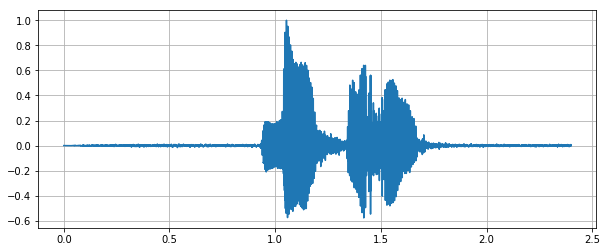

In [5]:
audio = normalize_audio(audio)
plt.figure(figsize=(10,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [6]:
def frame_audio(audio, FFT_size=512, hop_size=10, sample_rate=16000):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [7]:
hop_size = 10 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (241, 2048)


In [8]:
print("print frame:")
print(np.shape(audio_framed[100]))

print frame:
(2048,)


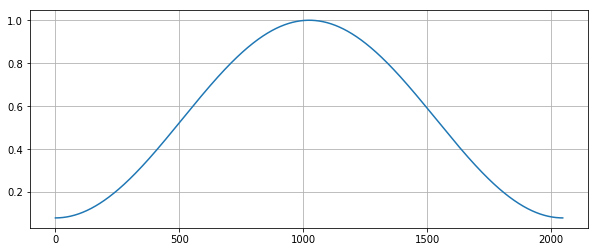

In [9]:
window = get_window("hamm", FFT_size, fftbins=True)
plt.figure(figsize=(10,4))
plt.plot(window)
plt.grid(True)

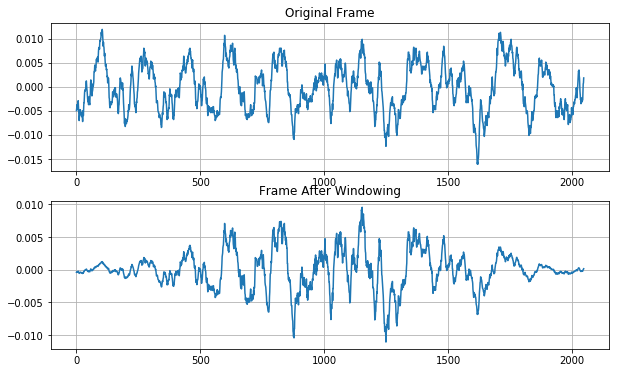

In [10]:
audio_win = audio_framed * window

ind = 50
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [11]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [12]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(241, 1025)


In [13]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 22

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


In [14]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs


In [15]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=16000)
filter_points

MEL min: 0.0
MEL max: 2840.023046708319


array([   0,   10,   21,   34,   49,   65,   83,  103,  125,  150,  178,
        209,  244,  282,  325,  374,  427,  487,  554,  629,  712,  805,
        908, 1024])

In [16]:
np.shape(mel_freqs)

(24,)

In [17]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

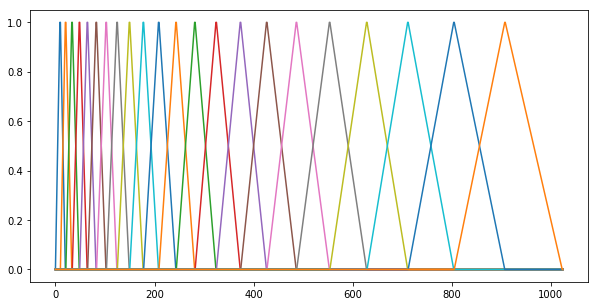

In [18]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(10,5))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [19]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

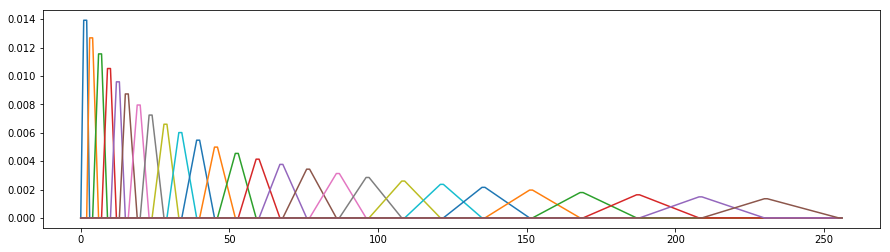

In [20]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [21]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


(26, 241)

In [22]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [23]:
dct_filter_num = 13

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(13, 241)

In [24]:
cepstral_coefficents

array([[           -inf,            -inf, -4.92339583e+02, ...,
        -2.47657632e+02, -2.43404100e+02, -2.45952390e+02],
       [            nan,             nan,  3.23443026e+01, ...,
         5.17683283e+01,  5.39558221e+01,  4.99848980e+01],
       [            nan,             nan, -4.27373686e+00, ...,
         1.43514558e+01,  1.41040231e+01,  9.74773993e+00],
       ...,
       [            nan,             nan, -5.43994624e+00, ...,
         2.66037234e+00,  3.82244823e+00,  1.67677294e+00],
       [            nan,             nan,  1.88060818e+00, ...,
        -1.48120062e+00,  4.84681660e-01, -1.34345802e+00],
       [            nan,             nan,  5.27846020e-01, ...,
        -1.90153167e+00, -3.58034958e-01, -2.61641121e+00]])

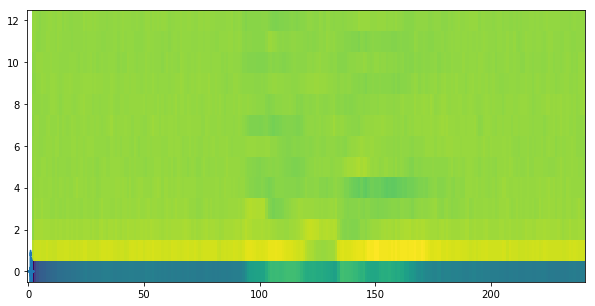

In [28]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');